# CSC713M MBTI and Writing Style: Multiclass Problem

MBTI and Writing Style.
This notebook performs machine learning concepts on the MBTI Personality Type dataset. This treats it as an NLP Multi-class problem, performing text classification for all 16 MBTIs instead of each indicator/letter.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Imports to be used.

In [2]:
# !pip install ftfy lightgbm xgboss

     |████████████████████████████████| 71kB 3.8MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41916 sha256=c11abed2034a493bc51df0eab8c32310f0c2369983d7d80202cae863cd253f8f
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [2]:
from ftfy import fix_encoding
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import math
import csv
import string
import re
from nltk.tokenize import RegexpTokenizer

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, RobustScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import plot_importance

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier

from collections import Counter
import wordcloud
import itertools
import collections
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy

pd.set_option('max_rows',1000000)
pd.set_option('max_columns',10000)
sns.set(rc={'figure.figsize':(15,10)})

# %load_ext autoreload
# %autoreload 2

In [3]:
def fix_encode(x):
  return fix_encoding(x)


# reads the csv file and converts it into a pandas dataframe
raw_data = pd.read_csv(
    'Data/mbti_1.csv',
    encoding="utf-8",
    quoting=csv.QUOTE_ALL
    )
print("Shape of the raw data", raw_data.shape)

# displays the first 5 entries
raw_data.head()

Shape of the raw data (8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
raw_data["posts"] = raw_data["posts"].apply(lambda x: fix_encode(x))

## EDA
We will use the sales prices of houses in Kansas City as our dataset. It has 21 columns:

1. **type** - (string) 4-letter MBTI personality type of a user.
2. **posts** - (string) A collection of 50 of their posts, separated by "|||".

Applies fix_encoding on all rows under `posts` column to fix any errors in encoding when loading the file.

Prints summary descriptive statistics about the `type` column.
Also includes the `value_counts` of all MBTI types in the dataset.


---


It can be seen from the dataset that the types are not normally distributed and are actually skewed. There are mo instances of I(ntrovert) types than E(xtrovert) ones, for example. 

In [5]:
print(raw_data.info())
print("------------------")
print(raw_data["type"].describe())
print("------------------")
print(raw_data["type"].value_counts(ascending=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB
None
------------------
count     8675
unique      16
top       INFP
freq      1832
Name: type, dtype: object
------------------
ESTJ      39
ESFJ      42
ESFP      48
ESTP      89
ISFJ     166
ENFJ     190
ISTJ     205
ENTJ     231
ISFP     271
ISTP     337
ENFP     675
ENTP     685
INTJ    1091
INTP    1304
INFJ    1470
INFP    1832
Name: type, dtype: int64


This section plots the users with respect to their MBTI types and their posts for further data visualization.

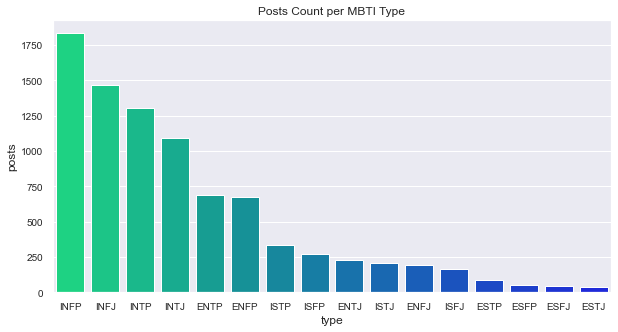

In [6]:
type_plot = raw_data.groupby('type').count()
type_plot.sort_values("posts", ascending=False, inplace=True)
# type_plot

plt.figure(figsize=(10, 5))
# type_plot["posts"].plot(kind='bar', title='Posts Count per MBTI Type')

sns.barplot(x=type_plot.index, y='posts', data=type_plot, palette='winter_r')
plt.title("Posts Count per MBTI Type")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('Figures/post-count-mbti.png',bbox_inches = 'tight', dpi=100)
plt.show()

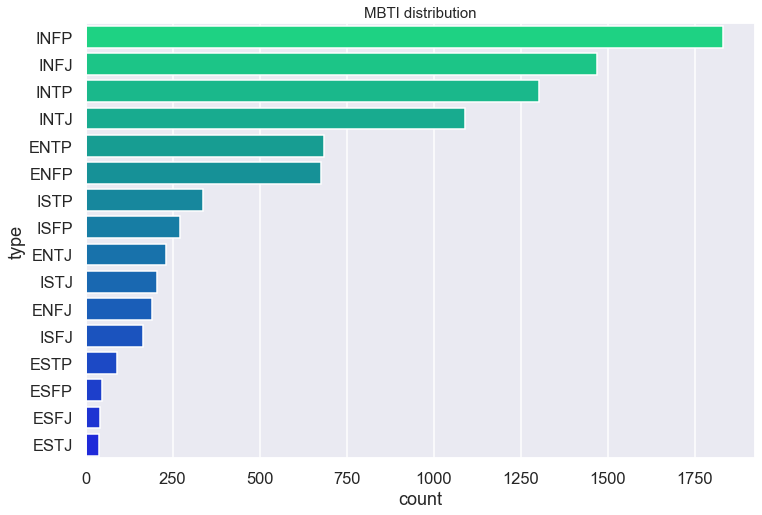

In [8]:
plt.figure(figsize=(12,8))
sns.countplot(y='type',data=raw_data, order=raw_data.type.value_counts().index, palette='winter_r')
sns.set_context('talk')
plt.title('MBTI distribution', fontsize=15)
plt.savefig('Figures/mbti-count.png',bbox_inches = 'tight', dpi=100)
plt.show()

In [9]:
def var_row(row):
    lst = []
    for word in row.split('|||'):
        lst.append(len(word.split()))
    return np.var(lst)

raw_data['word_count'] = raw_data['posts'].apply(lambda x: len(x.split())/50)
raw_data['variance_of_word_counts'] = raw_data['posts'].apply(lambda x: var_row(x))
raw_data.tail()

,type,posts,word_count,variance_of_word_counts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,15.92,125.3300
8671,ENFP,'So...if this thread already exists someplace ...,26.18,125.6144
8672,INTP,'So many questions when i do these things. I ...,18.96,169.7764
8673,INFP,'I am very conflicted right now when it comes ...,34.10,57.0336
8674,INFP,'It has been too long since I have been on per...,27.22,155.9200


In [10]:
raw_data.head()

,type,posts,word_count,variance_of_word_counts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576


c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 70.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 47.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 66.8% of the points canno

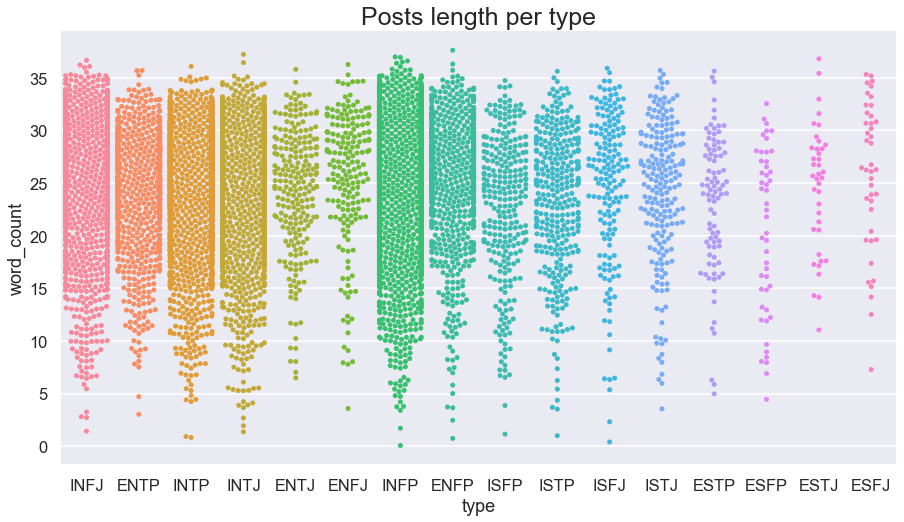

In [12]:
plt.figure(figsize=(15,8))
sns.swarmplot('type', 'word_count', data=raw_data)
sns.set_context('talk')
plt.title('Posts length per type', fontsize=25)
plt.savefig('Figures/mbti_posts_length.png')
plt.show()

This section visualizes the length of all 50 posts.

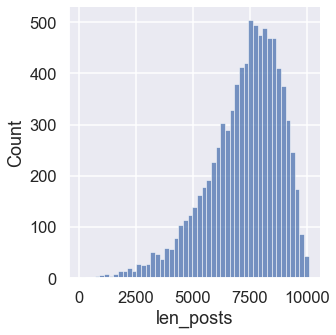

In [13]:
raw_data["len_posts"] = raw_data["posts"].apply(len)
sns.displot(raw_data["len_posts"]).set_titles("Distribution of length of posts")

,type,posts,word_count,variance_of_word_counts,len_posts,num_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11.12,135.2900,4652,50
1,ENTP,'I'm finding the lack of me in these posts ver...,23.40,187.4756,7053,50
2,INTP,'Good one _____ https://www.youtube.com/wat...,16.72,180.6900,5265,50
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21.28,181.8324,6271,50
4,ENTJ,'You're fired.|||That's another silly misconce...,19.34,196.4576,6111,50


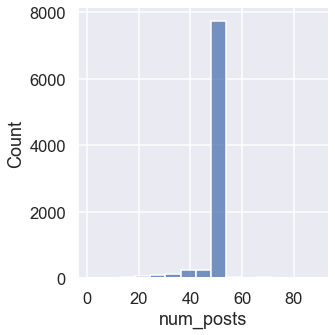

In [14]:
raw_data["num_posts"] = raw_data["posts"].apply(lambda x: len(x.split("|||")))
sns.displot(raw_data["num_posts"], kde=False).set_titles("Number of posts per user")

raw_data.head()

Extracts all the posts [individually] from `raw_data` and puts it in another DataFrame, `posts`.

In [15]:
def extract(posts, new_posts):
  for post in posts[1].split("|||"):
    new_posts.append((posts[0], post))

posts=[]
raw_data.apply(lambda x: extract(x, posts), axis = 1)
print("Number of users:", len(raw_data))
print("Number of posts:", len(posts))

# posts

Number of users: 8675
Number of posts: 422845


Makes a new DataFrame: `data`.

In [16]:
data = pd.DataFrame(posts, columns=["type", "posts"])
# 

In [17]:
data.head(5)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


Get the most frequently used words in the posts, and then plot them using a WordCloud. 

In [18]:
most_freq_words = list(data["posts"].apply(lambda x: x.split()))
most_freq_words = [x for y in most_freq_words for x in y]
Counter(most_freq_words).most_common(50)

[('I', 463694),
 ('to', 290296),
 ('the', 271111),
 ('a', 231152),
 ('and', 219676),
 ('of', 177901),
 ('you', 129537),
 ('is', 128915),
 ('that', 127521),
 ('in', 117384),
 ('my', 105005),
 ('it', 93656),
 ('for', 83151),
 ('have', 79840),
 ('with', 77180),
 ('but', 74834),
 ("I'm", 70560),
 ('be', 69359),
 ('are', 65107),
 ('like', 61449),
 ('not', 59700),
 ('an', 59057),
 ('on', 57126),
 ('was', 56169),
 ('me', 55821),
 ('as', 53400),
 ('this', 53053),
 ('just', 48449),
 ('about', 46334),
 ('think', 46270),
 ('or', 45764),
 ("don't", 44885),
 ('so', 43189),
 ('do', 40994),
 ('your', 40991),
 ('what', 38089),
 ('at', 37604),
 ('can', 37600),
 ('if', 37254),
 ('people', 35673),
 ('when', 34756),
 ('would', 32640),
 ('all', 31477),
 ('really', 31403),
 ('more', 31243),
 ('know', 31179),
 ('they', 29440),
 ('get', 28974),
 ('i', 27733),
 ('because', 27481)]

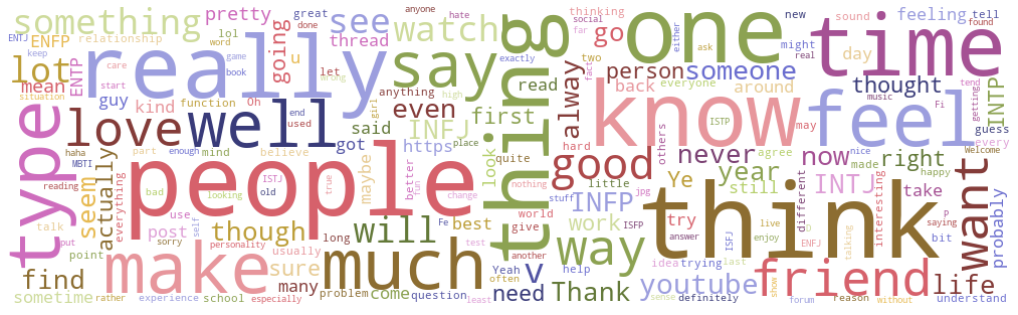

In [19]:
most_freq_wordcloud = wordcloud.WordCloud(width=1000, height=300, collocations=False, background_color='white', colormap='tab20b').generate(" ".join(most_freq_words))

plt.figure(figsize=(18, 10))
plt.imshow(most_freq_wordcloud, interpolation='bilinear')
_ = plt.axis("off")

In [20]:
types = np.unique(np.array(data['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [21]:
total = data.groupby(['type']).count()*50
total

,posts
type,
ENFJ,464400
ENFP,1638450
ENTJ,563650
ENTP,1688050
ESFJ,100900
ESFP,110750
ESTJ,96050
ESTP,216850
INFJ,3605250


Text(0.5, 1.0, 'Total posts for each personality type')

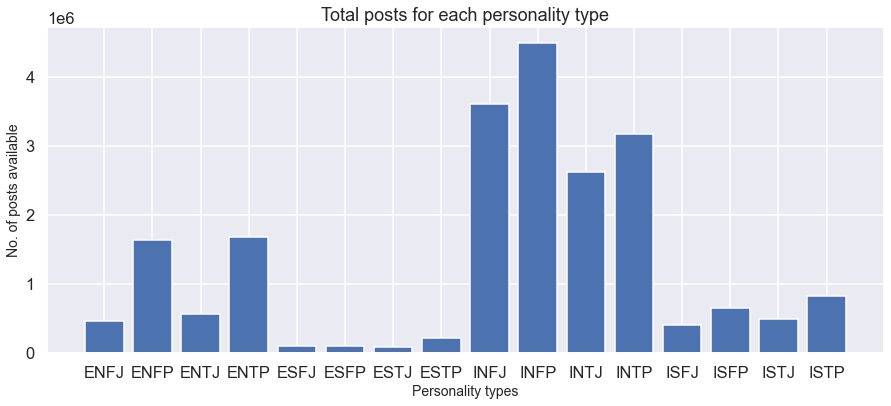

In [22]:
plt.figure(figsize = (15,6))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


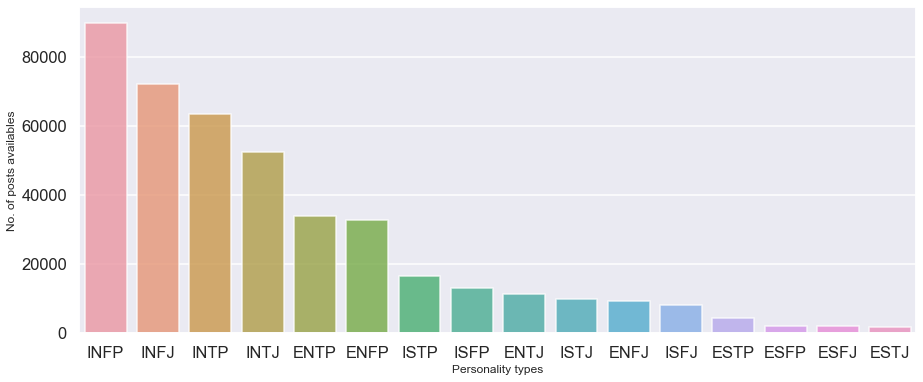

In [23]:
cnt_srs = data['type'].value_counts()
plt.figure(figsize=(15,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Personality types', fontsize=12)
plt.ylabel('No. of posts availables', fontsize=12)
plt.show()

In [24]:
words = list(data["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(40)

[('I', 463694),
 ('to', 290296),
 ('the', 271111),
 ('a', 231152),
 ('and', 219676),
 ('of', 177901),
 ('you', 129537),
 ('is', 128915),
 ('that', 127521),
 ('in', 117384),
 ('my', 105005),
 ('it', 93656),
 ('for', 83151),
 ('have', 79840),
 ('with', 77180),
 ('but', 74834),
 ("I'm", 70560),
 ('be', 69359),
 ('are', 65107),
 ('like', 61449),
 ('not', 59700),
 ('an', 59057),
 ('on', 57126),
 ('was', 56169),
 ('me', 55821),
 ('as', 53400),
 ('this', 53053),
 ('just', 48449),
 ('about', 46334),
 ('think', 46270),
 ('or', 45764),
 ("don't", 44885),
 ('so', 43189),
 ('do', 40994),
 ('your', 40991),
 ('what', 38089),
 ('at', 37604),
 ('can', 37600),
 ('if', 37254),
 ('people', 35673)]

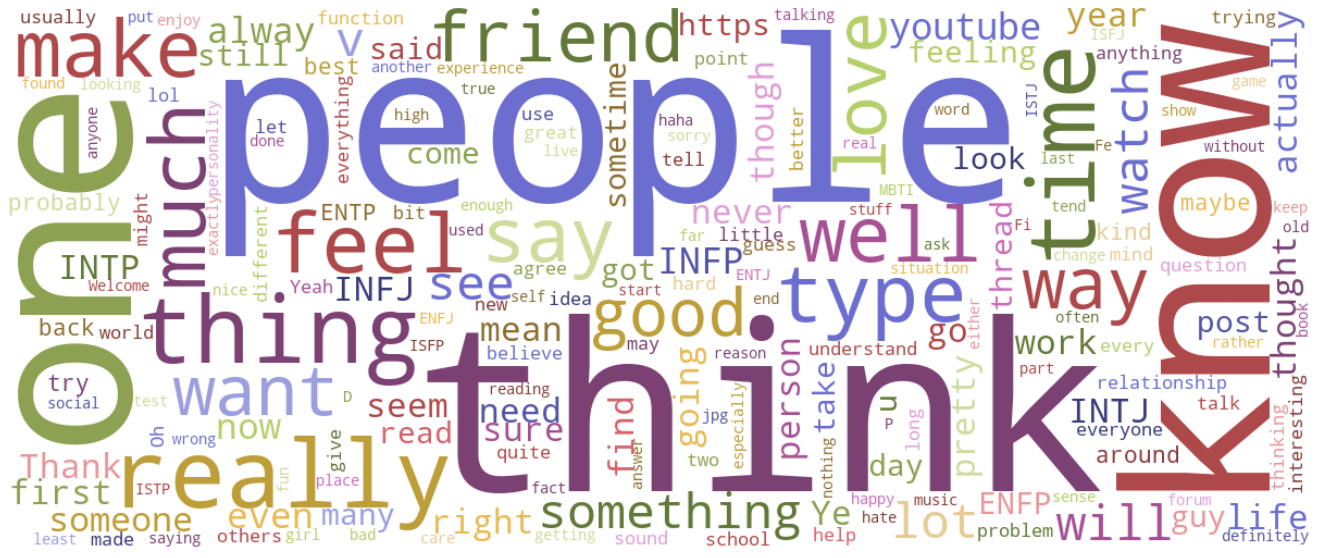

In [25]:
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(words))

# collocations to False  is set to ensure that the word cloud doesn't appear as if it contains any duplicate words
plt.figure(figsize=(25,10))
# generate word cloud, interpolation 
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

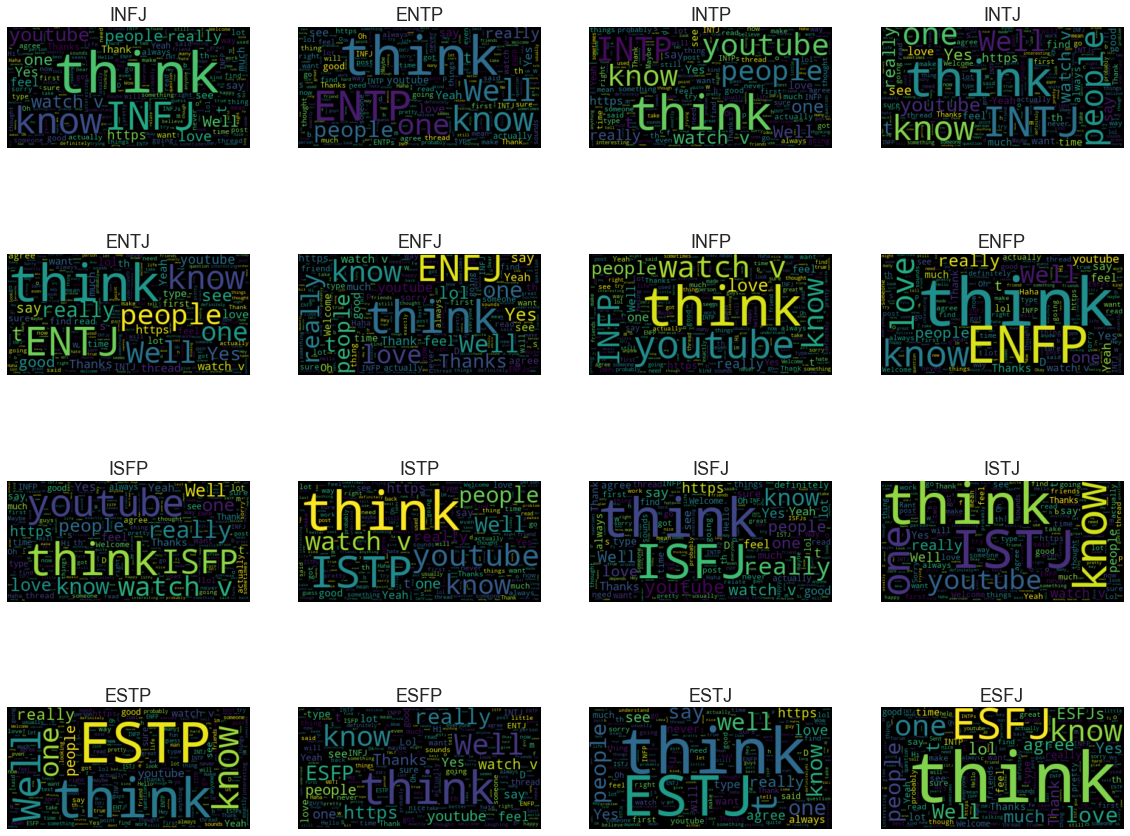

In [26]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(len(data['type'].unique()), sharex=True, figsize=(20,len(data['type'].unique())))
k = 0
for i in data['type'].unique():
    df_4 = data[data['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(i)
    ax[k].axis("off")
    k+=1

In [27]:
def extract(posts, new_posts):
    for post in posts[1].split("|||"):
        new_posts.append((posts[0], post))

posts = []
data.apply(lambda x: extract(x, posts), axis=1)
print("Number of users", len(data))
print("Number of posts", len(posts))
print("5 posts from start are:")
posts[0:5]

Number of users 422845
Number of posts 422845
5 posts from start are:


[('INFJ', "'http://www.youtube.com/watch?v=qsXHcwe3krw"),
 ('INFJ', 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg'),
 ('INFJ',
  'enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks'),
 ('INFJ', 'What has been the most life-changing experience in your life?'),
 ('INFJ',
  'http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.')]

## Data Pre-processing
This section will preprocess the posts. It will do the following things:

In [28]:
raw_data.posts.values[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

### Pre-Processing Proper

First, since the text is separated by `|||` without spaces in between, we change it into spaces. Afterwards, we perform the following operations.

1. First, we only retain words.
2. We lemmatize each word.
3. We remove URLs.
4. We also remove any mention of MBTIs in the text. 

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jerem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

STOP_WORDS = stopwords.words('english')

URL_REGEX = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

unique_type_list = [x.lower() for x in unique_type_list]

In [32]:
raw_data.shape

(8675, 6)

In [33]:
def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', r'', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', r'', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', r'', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
      for i in unique_type_list:
        df['posts'] = df['posts'].apply(lambda x: x.replace(i, ''))
        # pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        # pers_types = [p.lower() for p in pers_types]
        # p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df

data = preprocess_text(raw_data)

We perform lemmatization -- that is, getting the root of a given word (e.g., "memories" --> "memory).

In [34]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

def lemmatize_text(text):
  text = [lemmatiser.lemmatize(w) for w in w_tokenizer.tokenize(text)]
  text = " ".join(text)
  return text

data['lemma_posts'] = data.posts.apply(lemmatize_text)

In [35]:
data['posts'].head()

0           moments   sportscenter    plays   prank...
1     finding  lack    these posts very alarming   ...
2    good         course  which    know thats  bles...
3    dear     enjoyed  conversation  other   esoter...
4    youre fired   thats another silly misconceptio...
Name: posts, dtype: object

In [36]:
data['lemma_posts'].head()

0    moment sportscenter play prank what been most ...
1    finding lack these post very alarming boring s...
2    good course which know thats blessing curse do...
3    dear enjoyed conversation other esoteric gabbi...
4    youre fired thats another silly misconception ...
Name: lemma_posts, dtype: object

In here, we remove posts with less than `min_words` words -- because it's more than likely that after preprocessing, since we removed a ton of stuff, that some rows may be empty or near empty.

In [37]:
min_words = 15
print("Before : Number of posts", len(data)) 
data["no. of. words"] = data["posts"].apply(lambda x: len(re.findall(r'\w+', x)))
data = data[data["no. of. words"] >= min_words]

print("After : Number of posts", len(data))

Before : Number of posts 8675
After : Number of posts 8432


## Feature Engineering

resource: https://www.kaggle.com/rajshreev/mbti-personality-predictor-using-machine-learning#Feature-Engineering

In this section, we encode each unique MBTI type into a corresponding value pair using `LabelEncoder()` from the SKlearn library. 

We chose this over one-hot encoding primarily because we already have 16 predefined values.

In [38]:
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

In [39]:
mbti_encoder = LabelEncoder()

data['label'] = mbti_encoder.fit_transform(data.type)

C:\Users\jerem\AppData\Local\Temp\ipykernel_10304\2989058340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = mbti_encoder.fit_transform(data.type)


In [40]:
target = data.label

In [41]:
print(np.unique(raw_data.type))
print(np.unique(target))

['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [42]:
data.head(15)

,type,posts,word_count,variance_of_word_counts,len_posts,num_posts,lemma_posts,no. of. words,label
0,INFJ,moments sportscenter plays prank...,11.12,135.290000,4652,50,moment sportscenter play prank what been most ...,336,8
1,ENTP,finding lack these posts very alarming ...,23.40,187.475600,7053,50,finding lack these post very alarming boring s...,628,3
2,INTP,good course which know thats bles...,16.72,180.690000,5265,50,good course which know thats blessing curse do...,214,11
3,INTJ,dear enjoyed conversation other esoter...,21.28,181.832400,6271,50,dear enjoyed conversation other esoteric gabbi...,600,10
4,ENTJ,youre fired thats another silly misconceptio...,19.34,196.457600,6111,50,youre fired thats another silly misconception ...,312,2
5,INTJ,science perfect scientist claims that ...,29.82,97.720000,8589,50,science perfect scientist claim that that scie...,183,10
6,INFJ,cant draw nails haha those were done pro...,26.58,151.366400,7916,50,cant draw nail haha those were done profession...,769,8
7,INTJ,tend build collection things desktop th...,24.46,174.766400,6900,50,tend build collection thing desktop that frequ...,117,10
8,INFJ,sure thats good question distinction betwe...,14.76,207.112400,5325,50,sure thats good question distinction between d...,420,8
9,INTP,this position where have actually pe...,24.66,145.670400,7573,50,this position where have actually person vario...,106,11


In this section, we get the occurrences of words using `TfidfVectorizer()` which computes for the relevancy of each word. This means that the weight of a word is computed by its frequency count in a document as well as in how many documents the word appears in. 

The TF-IDF stands for Term Frequency - Inverse Document Frequency.

*Tf-idf = TF(t, d) x IDF(t)*

We can tune the `max_df` (the maximum threshold for term occurrences) and `min_df` (minimum threshold occurrence), as well as the `max_features`.

We vectorize the posts using `TfidfVectorizer()`.

The parameters mean that we keep the words appearing in 10% to 70% of the documents, and that we can also use up until 3500 max features. This can be fine-tuned.

In [43]:
print(STOP_WORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [44]:
tfidfvectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), max_df=0.7, min_df=0.1, stop_words=STOP_WORDS)

train = tfidfvectorizer.fit_transform(data['posts'])

In [45]:
train.shape

(8432, 549)

In [46]:
feature_names = list(enumerate(tfidfvectorizer.get_feature_names()))
feature_names[:25]

c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[(0, 'able'),
 (1, 'absolutely'),
 (2, 'across'),
 (3, 'actually'),
 (4, 'advice'),
 (5, 'afraid'),
 (6, 'agree'),
 (7, 'almost'),
 (8, 'alone'),
 (9, 'along'),
 (10, 'already'),
 (11, 'also'),
 (12, 'although'),
 (13, 'always'),
 (14, 'amazing'),
 (15, 'angry'),
 (16, 'another'),
 (17, 'answer'),
 (18, 'anymore'),
 (19, 'anyone'),
 (20, 'anything'),
 (21, 'anyway'),
 (22, 'appreciate'),
 (23, 'arent'),
 (24, 'around')]

## Model Building

We will use XGBoost, Logistic Regression, Support Vector Machines, and Multinomial Naive Bayes to perform multi-class text classification. 

Our train-test split will be 60-40.

We store all the accuracy scores of the models we will use here.

In [47]:
accuracies = {}

### Train-Test Split

In [48]:
data.shape

(8432, 9)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, stratify=target, random_state=191)

In [50]:
print((X_train.shape), (y_train.shape), (X_test.shape), (y_test.shape))
#(5077, 591) (5077,) (3385, 591) (3385,)

(5059, 549) (5059,) (3373, 549) (3373,)


### SMOTE

In [64]:
# !pip install imbalanced-learn

In [51]:
raw_data.head()

,type,posts,word_count,variance_of_word_counts,len_posts,num_posts,lemma_posts,no. of. words
0,INFJ,moments sportscenter plays prank...,11.12,135.2900,4652,50,moment sportscenter play prank what been most ...,336
1,ENTP,finding lack these posts very alarming ...,23.40,187.4756,7053,50,finding lack these post very alarming boring s...,628
2,INTP,good course which know thats bles...,16.72,180.6900,5265,50,good course which know thats blessing curse do...,214
3,INTJ,dear enjoyed conversation other esoter...,21.28,181.8324,6271,50,dear enjoyed conversation other esoteric gabbi...,600
4,ENTJ,youre fired thats another silly misconceptio...,19.34,196.4576,6111,50,youre fired thats another silly misconception ...,312


In [52]:
data.type.value_counts(ascending=True)

ESTJ      39
ESFJ      42
ESFP      47
ESTP      89
ISFJ     164
ENFJ     179
ISTJ     202
ENTJ     225
ISFP     266
ISTP     327
ENFP     634
ENTP     664
INTJ    1073
INTP    1280
INFJ    1433
INFP    1768
Name: type, dtype: int64

In [53]:
print(np.unique(raw_data.type))
np.unique(target)

['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [54]:
target.value_counts(ascending=True)

6       39
4       42
5       47
7       89
12     164
0      179
14     202
2      225
13     266
15     327
1      634
3      664
10    1073
11    1280
8     1433
9     1768
Name: label, dtype: int64

In [58]:
y_train[:10]

8461     9
6185     1
6730    11
6887     8
8180     8
2778     1
4126     8
8488    11
490      2
6533     5
Name: label, dtype: int32

In [59]:
from tqdm import tqdm
import imblearn
from imblearn.over_sampling import SMOTE

In [60]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

Class=9, n=1061 (6.250%)
Class=1, n=1061 (6.250%)
Class=11, n=1061 (6.250%)
Class=8, n=1061 (6.250%)
Class=2, n=1061 (6.250%)
Class=5, n=1061 (6.250%)
Class=14, n=1061 (6.250%)
Class=10, n=1061 (6.250%)
Class=3, n=1061 (6.250%)
Class=0, n=1061 (6.250%)
Class=15, n=1061 (6.250%)
Class=12, n=1061 (6.250%)
Class=13, n=1061 (6.250%)
Class=6, n=1061 (6.250%)
Class=7, n=1061 (6.250%)
Class=4, n=1061 (6.250%)


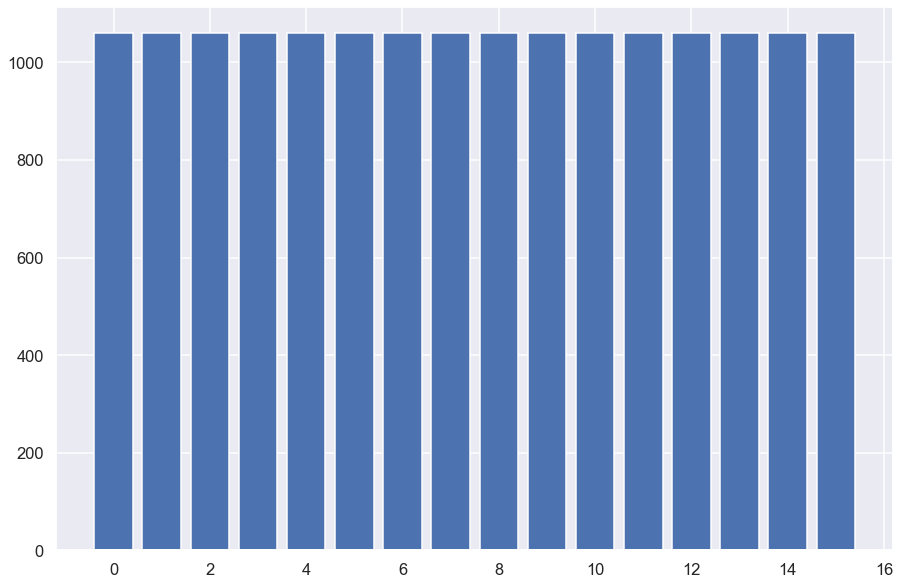

In [61]:
counter = Counter(y)

for k, v in counter.items():
  per = v / len(y) * 100
  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
  
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### XG boost Classifier

In [62]:
xgb = XGBClassifier()

xgb.fit(X, y)

y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
accuracies['XG Boost'] = accuracy * 100.0

print("Accuracy of XG Boost: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions))

Accuracy of XG Boost: 24.25%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.11      0.06      0.08       254
           2       0.00      0.00      0.00        90
           3       0.15      0.08      0.11       266
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        15
           7       0.00      0.00      0.00        35
           8       0.23      0.27      0.25       573
           9       0.27      0.54      0.36       707
          10       0.24      0.21      0.23       429
          11       0.26      0.30      0.28       512
          12       0.33      0.03      0.06        66
          13       0.12      0.01      0.02       106
          14       0.00      0.00      0.00        81
          15       0.09      0.01      0.01       131

    accuracy                           0.24      33

c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Logistic Regression

---

We use 'lbfgs' solver for optimization (the default) because they are the 4 solvers available in solving multi-class problems that can handle multinomial loss.

The results of the other solvers are below (not included in the code):


*   saga: 55.92%
*   saga: 55.92%
*   newton-cg: 51.82%

In [63]:
lr = LogisticRegression(solver='lbfgs', verbose=1)
lr.fit(X, y)

y_pred_lr = lr.predict(X_test)
predictions_lr = [round(value) for value in y_pred_lr]

accuracy = accuracy_score(y_test, predictions_lr)
accuracies["Logistic Regression"] = accuracy*100.0
print("Accuracy of LOGRES: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions_lr))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy of LOGRES: 19.54%
              precision    recall  f1-score   support

           0       0.05      0.11      0.07        72
           1       0.16      0.21      0.18       254
           2       0.06      0.12      0.08        90
           3       0.17      0.18      0.17       266
           4       0.00      0.00      0.00        17
           5       0.02      0.05      0.03        19
           6       0.00      0.00      0.00        15
           7       0.03      0.06      0.04        35
           8       0.30      0.20      0.24       573
           9       0.39      0.22      0.28       707
          10       0.26      0.20      0.23       429
          11       0.32      0.24      0.27       512
          12       0.05      0.09      0.07        66
          13       0.07      0.13      0.09       106
          14       0.04      0.09      0.05        81
          15       0.13      0.23      0.16       131

    accuracy                           0.20      3373

c:\Users\jerem\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished


### Support Vector Machines

---

Note that `SVC()` uses a one-vs-one approach in multi-class problems.


In [64]:
from sklearn.svm import SVC

svm = SVC(random_state=101)
svm.fit(X, y)

y_pred_svm = svm.predict(X_test)

predictions_svm = [round(value) for value in y_pred_svm]

accuracy = accuracy_score(y_test, predictions_svm)
accuracies['SVM'] = accuracy*100.0
print("Accuracy of SVM: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions_svm))

### Multinomial Naive Bayes
---

Specifically, we will use `MultinomialNB()`.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X, y)

y_pred_mnb = mnb.predict(X_test)

predictions_mnb = [round(value) for value in y_pred_mnb]

accuracy = accuracy_score(y_test, predictions_mnb)
accuracies['MNB'] = accuracy*100.0
print("Accuracy of MNB: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions_mnb))

Accuracy of MNB: 21.11%
              precision    recall  f1-score   support

           0       0.05      0.11      0.06        72
           1       0.17      0.18      0.18       254
           2       0.06      0.19      0.09        90
           3       0.20      0.17      0.18       266
           4       0.00      0.00      0.00        17
           5       0.02      0.05      0.03        19
           6       0.00      0.00      0.00        15
           7       0.04      0.09      0.06        35
           8       0.36      0.18      0.24       573
           9       0.39      0.29      0.33       707
          10       0.29      0.20      0.24       429
          11       0.36      0.25      0.30       512
          12       0.04      0.08      0.05        66
          13       0.10      0.21      0.14       106
          14       0.06      0.12      0.08        81
          15       0.14      0.26      0.18       131

    accuracy                           0.21      3373
  

### Comparing Algorithms

---

Note that this comparison is only for the non-neural-network models (i.e., XGB, LOGRES, SVM).

We can see that our model underfits the dataset -- model does not learn enough from the training data because all models are below 60% i.e., it's not that good.

In [ ]:
pd.DataFrame.from_dict(accuracies, orient='index', columns=['Accuracy (in %)'])

,Accuracy (in %)
XG Boost,25.731167
Logistic Regression,28.242245
SVM,28.094535
MNB,24.785820


In [ ]:
data.head()

,type,posts,no. of. words,label
0,INFJ,moments sportscenter plays prank...,422,8
1,ENTP,finding lack these posts very alarming eo...,793,3
2,INTP,good course which know thats bles...,252,11
3,INTJ,dear enjoyed conversation other eostoke...,766,10
4,ENTJ,youre fired eostokendot thats another silly...,399,2


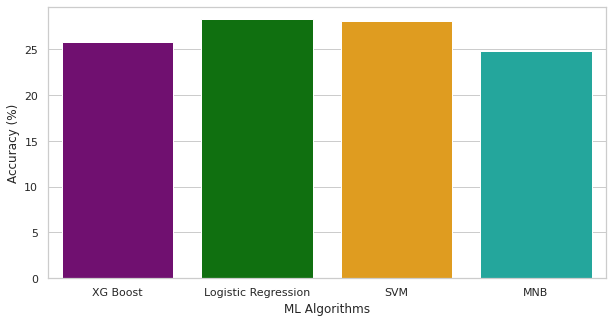

In [ ]:
colors = ["purple", "green", "orange", '#0FBBAE']

sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.yticks=(np.arange(0, 100, 10))
plt.ylabel("Accuracy (%)")
plt.xlabel("ML Algorithms")

sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

## Model Building: `Word Vectors`

---



In this section, instead of using `CountVectorizer()` to vectorize the features, we use pre-trained word vectors -- specifically, GloVe, to represent the inputs.

One big downside of using pre-trained word vectors, however, is that it can't handle out-of-vocabulary (OOV) words or unknowns -- in other words, there is no known vector for such words. 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(processed_df.posts, target, test_size=0.4, stratify=target, random_state=101)

print((X_train.shape), (y_train.shape), (X_test.shape), (y_test.shape))

#(4993, 98508) (4993,) (3329, 98508) (3329,)

(4993,) (4993,) (3329,) (3329,)


---



In [ ]:
print(processed_df['no. of. words'].max())
print(processed_df['no. of. words'].min())

1375
30


In this subsection, we now load the GloVe pre-trained word embeddings. For this experiment, we used the GloVe file with 300 dimensions and 42 billion tokens. 

The file is available here: https://nlp.stanford.edu/projects/glove/

---



In [ ]:
import tqdm
# from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

glove_file = '/content/drive/MyDrive/misc. class files/CSC713M/Project/glove.42B.300d.txt'

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

TOP_K = 50
maxlen = 50

#Tokenize the sentences
tokenizer = Tokenizer(num_words=TOP_K)

#preparing vocabulary
tokenizer.fit_on_texts(list(X_train))

#converting text into integer sequences
X_train_seq  = tokenizer.texts_to_sequences(X_train) 
X_test_seq = tokenizer.texts_to_sequences(X_test)

#padding to prepare sequences of same length
X_train_seq  = pad_sequences(X_train_seq, padding='post', truncating='post', maxlen=maxlen)
X_test_seq = pad_sequences(X_test_seq, padding='post', truncating='post', maxlen=maxlen)

In [ ]:
size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

74144


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(glove_file)

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1917494 word vectors.


In [ ]:
from sklearn.utils import shuffle

def augment_text(df, label, mbti, samples=500, aug_p=0.2, stopwords=STOP_WORDS):
  aug_w2v.aug_p=aug_p
  new_text = []

  #estj = 6
  df_n = df[df.label==label].reset_index(drop=True)

  for i in tqdm(np.random.randint(0, len(df_n), samples)):
    text = df_n.iloc[0]['posts']
    augmented_text = aug_w2v.augment(text)
    new_text.append(augmented_text)
  
  new=pd.DataFrame({'type': mbti, 'posts': new_text, 'no. of. words': 0, 'label': label})
  df=shuffle(df.append(new).reset_index(drop=True))
  return df

In [ ]:
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM with 1 embedding layer and 1 dense layer

In [ ]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [ ]:
model=Sequential()

#embedding layer
model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False)) 

#lstm layer
model.add(LSTM(64,return_sequences=True,dropout=0.2))

#Global Maxpooling
model.add(GlobalMaxPooling1D())

#Dense Layer
model.add(Dense(64,activation='relu')) 
model.add(Dense(1,activation='sigmoid')) 

#Add loss function, metrics, optimizer
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["acc"]) 

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3)  
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  

#Print summary of model
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          22243200  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 22,471,169
Trainable params: 227,969
Non-trainable params: 22,243,200
_________________________________________________________________
None


In [ ]:
history = model.fit(np.array(X_train_seq),np.array(y_train),batch_size=32,epochs=10,validation_data=(np.array(X_test_seq),np.array(y_test)),verbose=1,callbacks=[es,mc])

In [ ]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

#evaluation 
_,val_acc = model.evaluate(X_test_seq,y_test, batch_size=128)
print(val_acc)

27/27 [==============================] - 8s 292ms/step - loss: -187.9447 - acc: 0.0742
0.074196457862854


Links for reference:

https://www.analyticsvidhya.com/blog/2020/03/pretrained-word-embeddings-nlp/

https://www.kaggle.com/rajshreev/mbti-personality-predictor-using-machine-learning#Pre-Processing-Stage

https://www.kaggle.com/rkuo2000/mbti-rnn

https://www.kaggle.com/anasofiauzsoy/myers-briggs-types-with-tensorflow-bert/notebook


https://towardsdatascience.com/pre-trained-word-embedding-for-text-classification-end2end-approach-5fbf5cd8aead

https://www.kaggle.com/eswarbabu88/toxic-comment-glove-logistic-regression/execution

**DATA AUGMENTATION:**

https://github.com/makcedward/nlpaug?fbclid=IwAR3F0mfHg5g-Tq1tzp7eDn49lnN0It69p2p5apMlhogu2nQoHJxV8ZZqcjg

https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28

https://towardsdatascience.com/data-augmentation-library-for-text-9661736b13ff

https://neptune.ai/blog/data-augmentation-nlp 

https://neptune.ai/blog/document-classification-small-datasets



In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as naf

from nlpaug.util import Action

In [ ]:
from nlpaug.util.file.download import DownloadUtil
DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.')

Words are substituted or switched out based on how close they are in a GloVe embedding.

In [ ]:
aug_w2v = naw.WordEmbsAug(model_type='glove', model_path='/content/glove.6B.200d.txt', action='substitute')

In [ ]:
text = data.iloc[2]['posts']
text

'good         course  which    know thats  blessing   curse   does being absolutely positive that   your best friend could   amazing couple count   than      more  could  madly  love  case  reconciled  feelings which      didnt thank    link   socalled tisi loop    stem from  current topicobsession   deadly  like when youre stuck  your  thoughts  your mind just wanders  circles feels truly terrible    have  noticed  peculiar vegetation     have    look down   grass dozens  different plant species there      imagine that hundreds  years later whenif soil    smiths  never    ever    often find myself spotting faces  marble tileswood   this  yearold sentence   incredibly accurate  beautiful description    havent visited this website   last  years  whoever reads this  maybe even remembers  which  highly doubt        when    your garden until   writing songs  sing them together with dozens  crickets while playing your acoustic guitar   this   most ish thread  ever seen    wouldnt  able  loo

In [ ]:
aug_w2v.aug_p = 0.2
print("Augmented Text: ")
for i in range(5):
  augmented_text = aug_w2v.augment(text)
  print(augmented_text)

Augmented Text: 
good course which know thats orthodox curse does being absolutely positive that your best friend could amazing couple count than more could madly love case reconciled feelings which didnt thank link vitalic tisi loop stem from current topicobsession deadly instead when youre stuck your thoughts your mind just wanders influence feels truly terrible have noticed peculiar vegetation have look down grass dozens different plant species there imagine that hundreds years later whenif soil smiths never ever often find myself spotting faces marble tileswood this yearold sentence passionate accurate beautiful description havent visited this website last years whoever reads this maybe even remembers which highly doubt when your garden until writing songs sing them together with dozens crickets while likes your acoustic guitar this most ish thread ever been wouldnt able look painting entire life knew that picked over human being drawing background animation which working right sho